<a href="https://colab.research.google.com/github/pranav033-ctrl/Pnuenmonia-Detection-Using-CNN-based-Pre-trained-Models/blob/main/Pneumonia_Detection_Base_Model-base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
! pip install -q kaggle

In [7]:
 ! mkdir ~/.kaggle

In [8]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ppranav033","key":"ea3bc2c44edac99130862f19e1ed308c"}'}

In [9]:
! cp kaggle.json ~/.kaggle/

In [10]:
! chmod 600 ~/.kaggle/kaggle.json

In [11]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              235KB  2021-10-21 20:52:33          14475  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           8689  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           3864  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3233  
fatiimaezzahra/famous-iconic-women                          Famous Iconic Wo

In [12]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:26<00:00, 66.2MB/s]
100% 2.29G/2.29G [00:26<00:00, 92.8MB/s]


In [ ]:
! unzip chest-xray-pneumonia.zip

In [14]:
!pwd

/content


In [26]:
import tensorflow
import pandas as pd
import numpy as np
import os
import keras
from tensorflow.keras.applications import DenseNet169, DenseNet121, MobileNet
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout ,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt

In [16]:
training_dir='./chest_xray/train/'
validation_dir='./chest_xray/val/'
test_dir='./chest_xray/test/'

In [17]:
test_ds = image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=16,
    image_size=(224, 224),
    )

Found 624 files belonging to 2 classes.


In [18]:
train_ds = image_dataset_from_directory(
    directory=training_dir,
    shuffle=True,
    labels='inferred',
    label_mode='binary',
    batch_size=16,
    image_size=(224, 224),
    )

Found 5216 files belonging to 2 classes.


In [19]:
validation_ds = image_dataset_from_directory(
    directory=validation_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=16,
    image_size=(224, 224),
    )

Found 16 files belonging to 2 classes.


In [20]:
data_augmentation = tensorflow.keras.Sequential([
  tensorflow.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tensorflow.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  #tensorflow.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

In [21]:
test_ds


<BatchDataset shapes: ((None, 224, 224, 3), (None, 1)), types: (tf.float32, tf.float32)>

In [22]:
base_model = DenseNet169(
    include_top=True,
    weights="imagenet",
    input_shape=(224,224,3)
)
base_model.summary()

58556416/58541896 [==============================] - 1s 0us/step
Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________

In [29]:
x= base_model.output

preds=Dense(2,activation='softmax')(x)

In [ ]:
model=Model(inputs=base_model.input,outputs=preds)
model.summary()

In [31]:
base_model.trainable = False

In [ ]:
# for layer in base_model.layers[:1]:
#   layer.trainable =  True

In [32]:
len(model.trainable_variables)

2

In [38]:
model.compile(optimizer = 'Adam' ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [34]:
initial_epochs = 20

In [39]:
history=model.fit(x=train_ds,
                           validation_data=validation_ds,
                           epochs=initial_epochs,
                           verbose=1)

Epoch 1/20
326/326 [==============================] - 94s 166ms/step - loss: 0.5941 - accuracy: 0.7431 - val_loss: 0.7291 - val_accuracy: 0.5000
Epoch 2/20
326/326 [==============================] - 52s 158ms/step - loss: 0.5050 - accuracy: 0.7429 - val_loss: 0.7828 - val_accuracy: 0.5000
Epoch 3/20
326/326 [==============================] - 53s 160ms/step - loss: 0.4731 - accuracy: 0.7435 - val_loss: 0.8161 - val_accuracy: 0.5000
Epoch 4/20
326/326 [==============================] - 53s 159ms/step - loss: 0.4557 - accuracy: 0.7531 - val_loss: 0.8395 - val_accuracy: 0.6250
Epoch 5/20
326/326 [==============================] - 53s 160ms/step - loss: 0.4449 - accuracy: 0.7651 - val_loss: 0.8594 - val_accuracy: 0.6250
Epoch 6/20
326/326 [==============================] - 53s 160ms/step - loss: 0.4376 - accuracy: 0.7818 - val_loss: 0.8767 - val_accuracy: 0.6250
Epoch 7/20
326/326 [==============================] - 53s 160ms/step - loss: 0.4326 - accuracy: 0.7849 - val_loss: 0.8900 - val_ac

In [41]:
score = model.evaluate(test_ds, verbose = 1) 

39/39 [==============================] - 7s 167ms/step - loss: 0.6475 - accuracy: 0.7083


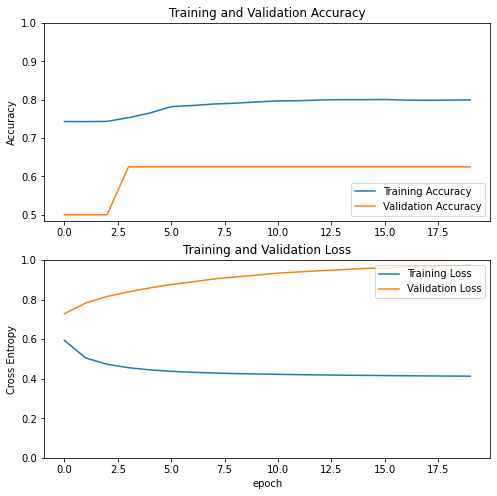

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()